### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [128]:
import numpy as np 
import scipy
from scipy.stats import uniform, norm, rv_histogram
from scipy import stats
import matplotlib.pyplot as plt
from scipy import optimize
import chainconsumer
import corner
import dynesty

# 1.1

In [28]:
time, flux, ferr = np.load('../../../homeworks/hw_data/hw5_data_1.npy').T
data1 = np.load('../../../homeworks/hw_data/hw5_data_1.npy').T

Text(0, 0.5, 'flux')

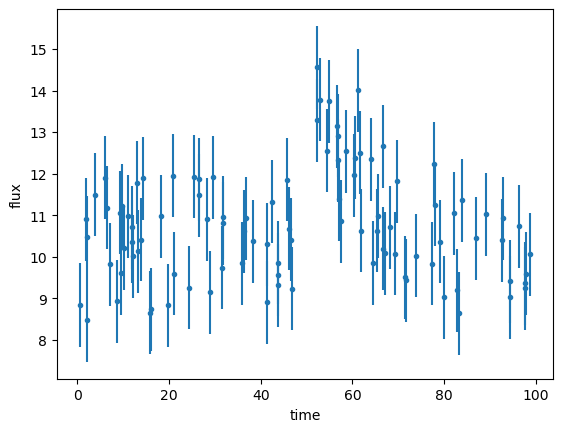

In [166]:
plt.errorbar(time, flux, ferr, fmt='.')
#plt.gca().invert_yaxis() if magnitudes
plt.xlabel('time')
plt.ylabel('flux')

# 1.2

In [151]:
# LSS cannibalized from HW4

# LSS Functions to do a burst/exp tail fit, and compute the likelihood
def sb_exptail(theta, time):
    """model of background with sharp bust + exponential tail"""
    # theta = [b, A, t0, ln(alph)]
    y = np.zeros_like(time)
    for idx, t in enumerate(time):
        if t < theta[2]:
            y[idx] = theta[0]
        else:
            y[idx] = theta[0] + theta[1] * np.exp(-np.exp(theta[3])*(t-theta[2]))
    return y

# LSS compute the data log-likelihood given the model
def logL(theta, data, model=sb_exptail):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

In [31]:
# LSS testing logL with by eye values
eye = [10.5, 4, 50, 0.5]
print('eye:', logL(eye, data1))
badeye = [8, 10, 20, 0.5]
print('badeye: ', logL(badeye, data1))
# LSS looks like it is working?

eye: -168.83510460949267
badeye:  -551.0459574086537


# 1.3

In [157]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc


def Prior(x):
    # LSS create uniform priors for b, A, t0, alph
    prior_b = uniform(loc=0, scale=50).pdf(x[0])
    prior_A = stats.uniform.pdf(x[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(x[2], loc=0, scale=100)
    prior_alph = stats.uniform.pdf(x[3], loc=-5, scale=10)
    return  prior_b * prior_A * prior_t0 * prior_alph


def logPrior(x):
    return np.log(Prior(x))

# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# LSS make function to calc loglik with data
def lnlik(x):
    return logL(x, data1)

# intialize sampler
sampler = ptmcmc(ndim, lnlik, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

In [158]:
# sampler for N steps
N = int(3e5)
x0 = np.array([10., 10., 10., 2.3])
#sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)
sampler.sample(x0, N, SCAMweight=40, AMweight=15, DEweight=60)

Finished 0.33 percent in 5.196754 s Acceptance rate = 0.913

/var/folders/1y/5f87nyls7mnbqvgd2zgz0lmc0000gr/T/ipykernel_29281/2615343234.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(Prior(x))


Finished 3.33 percent in 45.809405 s Acceptance rate = 0.375278Adding DE jump with weight 60
Finished 100.00 percent in 2162.222687 s Acceptance rate = 0.293157
Run Complete


# 1.4

In [159]:
# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')
print(chain.shape[0])
import acor
thin = int(acor.acor(chain[:,0])[0])
burnin = 0.33*chain.shape[0]
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(burnin) + ' samples.')
paramnames = ['b', 'A', 't0', 'alph']

c_bt = chain[int(burnin):,:]

30001
Taking every n = 174 samples based on ac length.
Burning first n = 9900.33 samples.


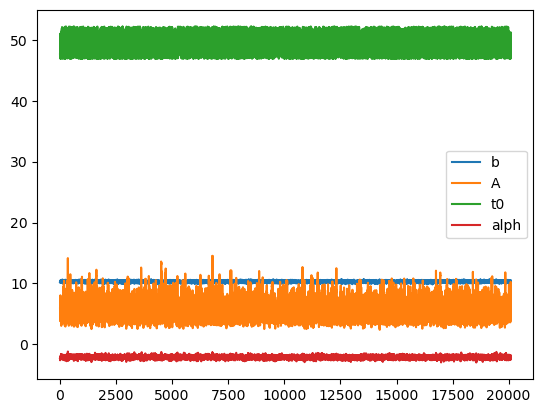

In [160]:
for idx in range(4):
    plt.plot(c_bt[:,idx], label=paramnames[idx])

plt.legend()
plt.show()

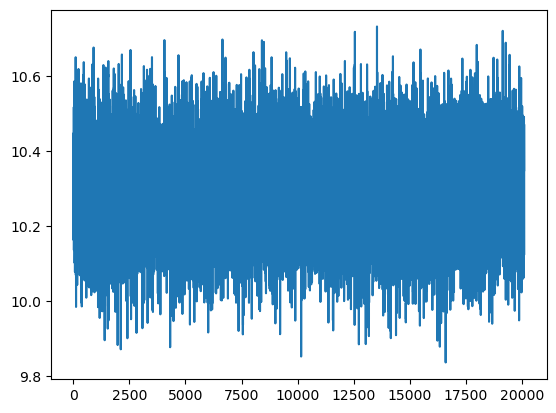

In [161]:
plt.plot(c_bt[:, 0])

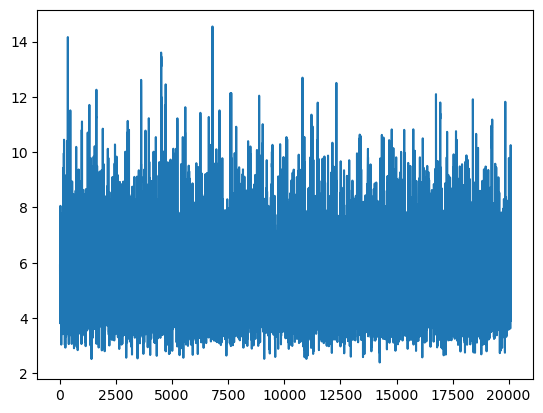

In [162]:
plt.plot(c_bt[:, 1])

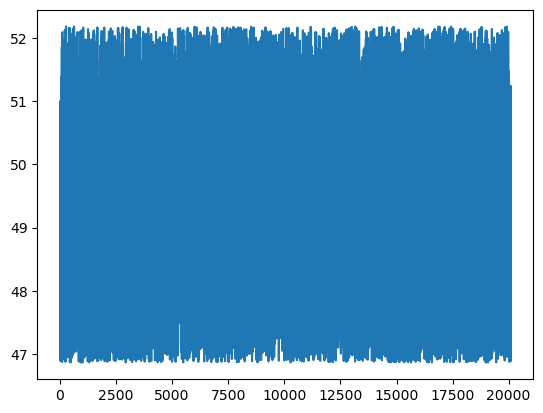

In [163]:
plt.plot(c_bt[:, 2])

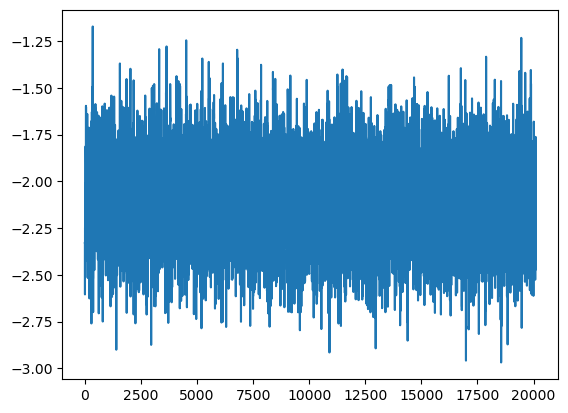

In [164]:
plt.plot(c_bt[:, 3])

# 1.5

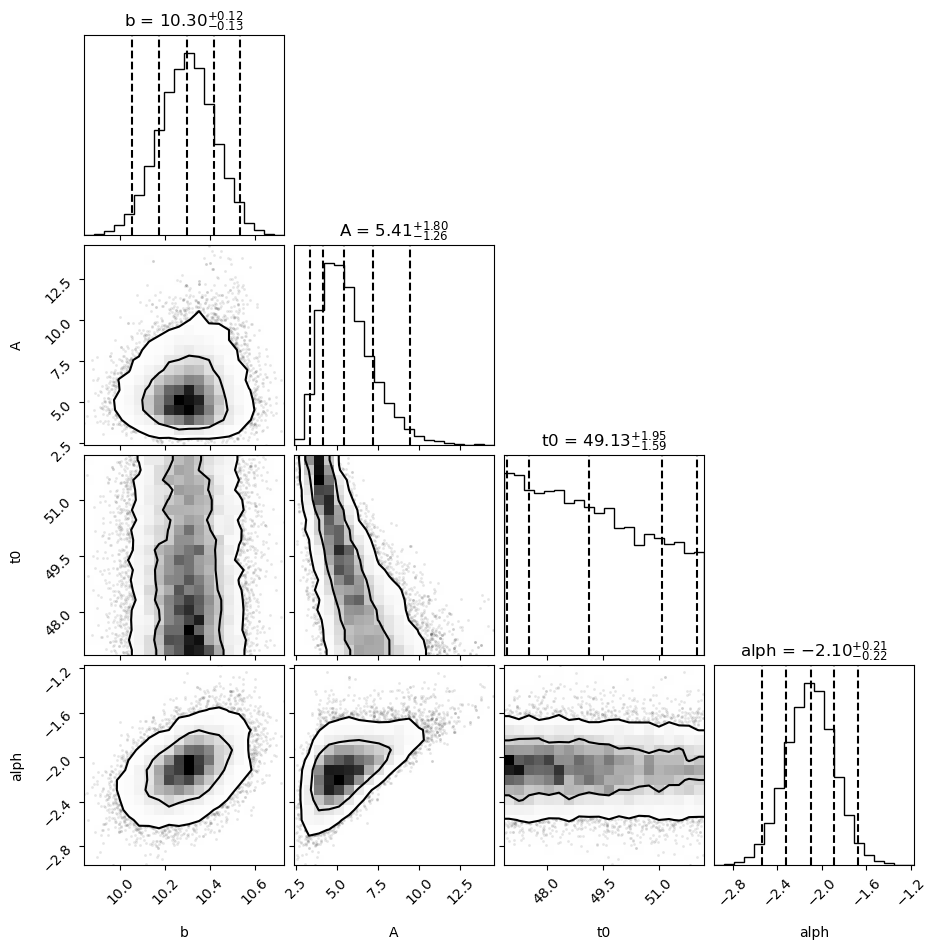

In [165]:
corner.corner(c_bt[:,:-4], labels=paramnames, show_titles=True, 
              levels=(0.68, 0.95), quantiles=[0.025, 0.16, 0.5, 0.84, 0.975],
              title_quantiles=[.16, .5, .84]);

SRT: Very good, Levi. Just be careful with the labeling. This shows log alpha.

# 1.6

In [108]:
sampleidx = np.random.choice(c_bt.shape[0], size=100)

In [109]:
sampleidx

array([15811, 17849,  2626,  1888, 12631,  1058, 16839, 13476, 16041,
       15281, 18598,  9109,  6170,  8819,   932,  2326, 12856, 15545,
       10908, 18410,   779,  9826, 18410,  2890, 12467,  4211,  7934,
       13627,   745, 11653,   461,  9023, 13489, 19959,  5757,  3068,
       14857,  8780,  5833,  8182,  5292, 15094, 15129, 14424, 13676,
        9063,  2107, 11234,  7677, 17176, 10042,  9990, 18110, 14850,
        4801, 13914,  5860, 13845, 11144,  3652,  7881,  9818, 19496,
       15387,  1804,  7807,  2254, 13315,  7912, 11872,  9015, 19571,
       11496, 15498, 18047, 14290, 11381,  5275,  4565, 19193,  6910,
       10646, 15431,  2135,  9531, 10875,  6485, 19602,  7735,  1994,
       12032,  7768,  7771,  8466, 14925, 17161,  8538, 19400, 17779,
        7248])

In [114]:
ypred_samples = np.zeros((100,100))
for i, s in enumerate(sampleidx):
    ypred_samples[i] = sb_exptail(c_bt[s,:-4], time)

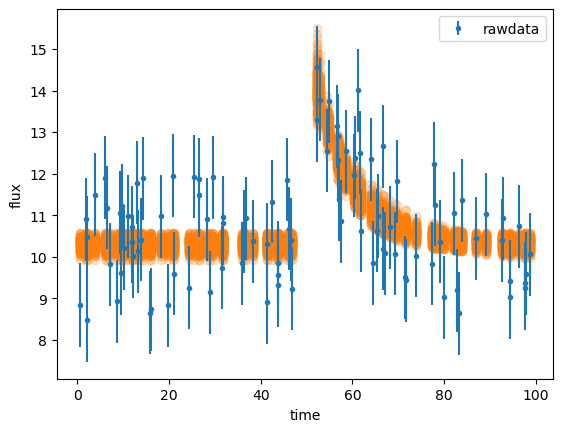

In [136]:
plt.errorbar(time, flux, ferr, label='rawdata', fmt='.')
#plt.gca().invert_yaxis() if magnitudes
for i in range(100):
    plt.scatter(time, ypred_samples[i], alpha=0.2, c='C1')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()

SRT: Good. You can join up the predicted values or plot the predictions on a finer grid than the data though.

# 1.7

In [139]:
# LSS new function for gaussian profile model
def gaussprof(theta, time):
    """model of background with gaussian profile"""
    # theta = [b, A, t0, sigw]
    y = np.zeros_like(time)
    y = theta[0] + theta[1] * np.exp((-(time-theta[2])**2)/(2*(np.exp(theta[3])**2)))
    return y

In [140]:
logL([10, 10, 10, 1], data1, model=gaussprof)

-593.138458966147

In [141]:
def Prior_gaussprof(x):
    # LSS create uniform priors for b, A, t0, sigw
    prior_b = uniform(loc=0, scale=50).pdf(x[0])
    prior_A = stats.uniform.pdf(x[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(x[2], loc=0, scale=100)
    prior_sigw = stats.uniform.pdf(x[3], loc=-2, scale=4)
    return  prior_b * prior_A * prior_t0 * prior_sigw

In [142]:

def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    tf = np.zeros_like(u)
    tf[0] = 50 * u[0]
    tf[1] = 50 * u[1]
    tf[2] = 100 * u[2]
    tf[3] = 2 * (2. * u[3] - 1.)
    return tf

def lnlik_GP(x):
    return logL(x, data1, model=gaussprof)

In [143]:
ndim = 4
sampler = dynesty.NestedSampler(lnlik_GP, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

iter: 4025 | bound: 47 | nc: 178 | ncall: 52357 | eff(%):  7.688 | loglstar:   -inf < -178.674 <    inf | logz: -186.416 +/-  0.117 | dlogz: 31.288 >  0.509                                          /Users/levischult/miniconda3/envs/astr8070/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
iter: 4068 | bound: 62 | nc: 28 | ncall: 63633 | eff(%):  6.393 | loglstar:   -inf < -178.317 <    inf | logz: -186.346 +/-  0.117 | dlogz: 31.132 >  0.509                                           /Users/levischult/miniconda3/envs/astr8070/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning:

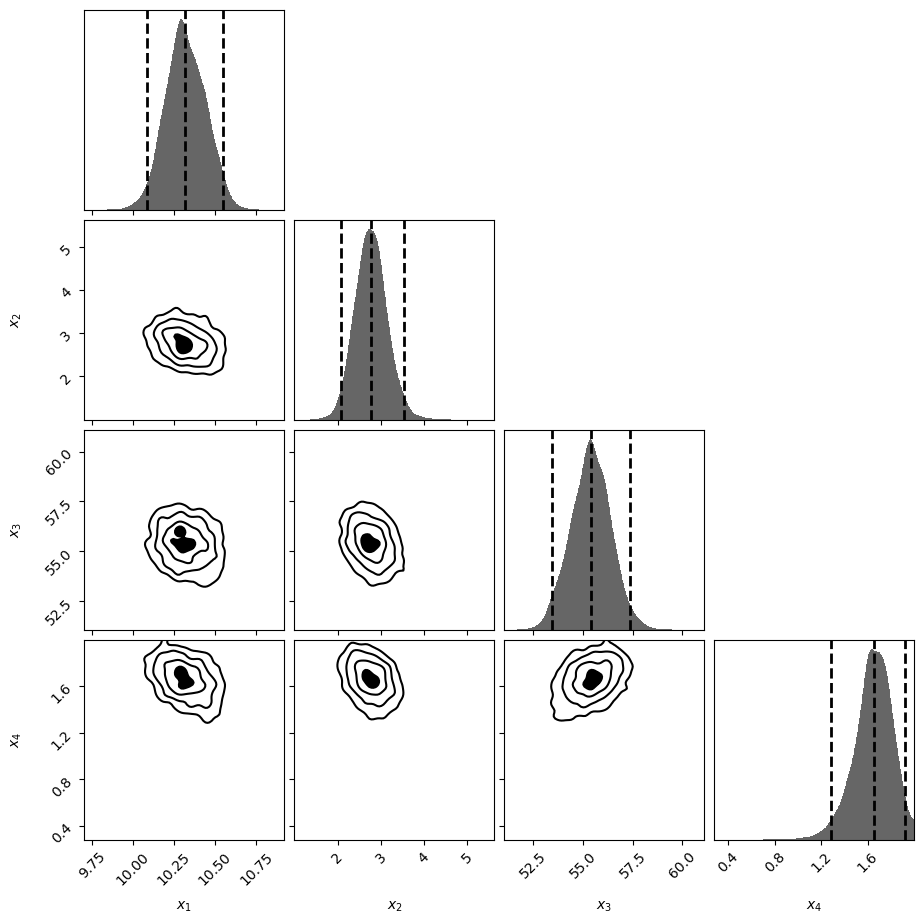

In [144]:
from dynesty import plotting as dyplot

cfig, caxes = dyplot.cornerplot(sresults)

* do dynesty on burst exp to get evidence

In [152]:
def ptform_bexp(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    tf = np.zeros_like(u)
    tf[0] = 50 * u[0]
    tf[1] = 50 * u[1]
    tf[2] = 100 * u[2]
    tf[3] = 5 * (2. * u[3] - 1.)
    return tf

In [154]:
ndim = 4
sampler_bexp = dynesty.NestedSampler(lnlik, ptform_bexp, ndim)
sampler_bexp.run_nested()
sresults_bexp = sampler_bexp.results

iter: 3975 | bound: 98 | nc: 81 | ncall: 91181 | eff(%):  4.359 | loglstar:   -inf < -178.819 <    inf | logz: -185.495 +/-  0.109 | dlogz: 34.435 >  0.509                                           /Users/levischult/miniconda3/envs/astr8070/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
iter: 4015 | bound: 111 | nc: 597 | ncall: 100721 | eff(%):  3.986 | loglstar:   -inf < -178.638 <    inf | logz: -185.472 +/-  0.109 | dlogz: 34.331 >  0.509                                        /Users/levischult/miniconda3/envs/astr8070/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning:

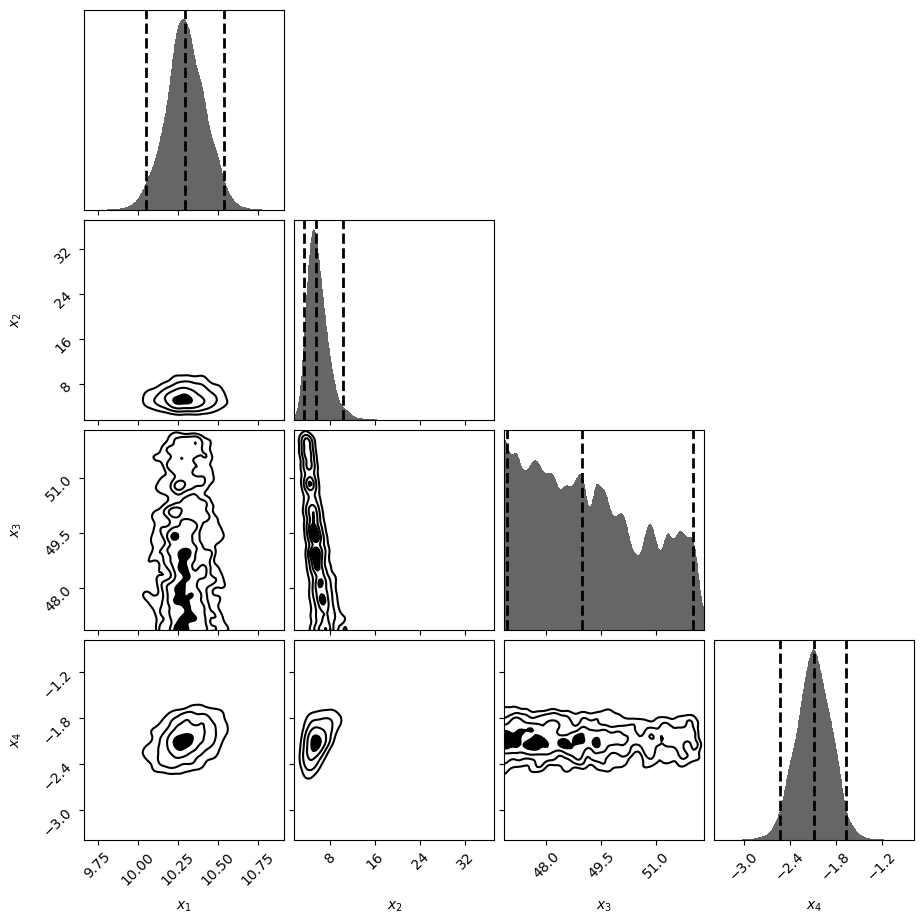

In [156]:
cfig, caxes = dyplot.cornerplot(sresults_bexp)

SRT: Excellent!

## Bayes Factor

In [150]:
print(sresults['logz'][-1], '+/-', sresults['logzerr'][-1])

-159.6927802904456 +/- 0.3022794624088726


In [155]:
print(sresults_bexp['logz'][-1], '+/-', sresults_bexp['logzerr'][-1])

-155.48278512840938 +/- 0.299837235281555


In [167]:
print('log BF for gauss profile / burst exponential:', 
      sresults['logz'][-1] - sresults_bexp['logz'][-1])

log BF for gauss profile / burst exponential: -4.209995162036222


SRT: Correct, within uncertainties.

* looking at gaussian profile model since it seems burst exponential fits WAY better

In [174]:
# LSS burning!
GPsamples = sresults['samples'][int(0.25*sresults['samples'].shape[0]):, :]

In [175]:
sampleidx = np.random.choice(GPsamples.shape[0], size=100)
ypred_samples_GP = np.zeros((100,100))
for i, s in enumerate(sampleidx):
    ypred_samples_GP[i] = gaussprof(GPsamples[s,:], time)

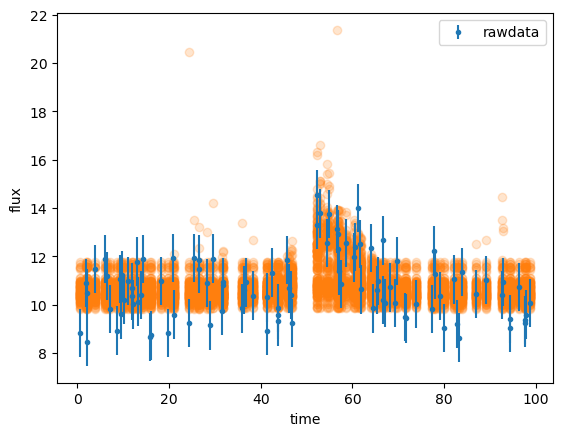

In [176]:
plt.errorbar(time, flux, ferr, label='rawdata', fmt='.')
#plt.gca().invert_yaxis() if magnitudes
for i in range(100):
    plt.scatter(time, ypred_samples_GP[i], alpha=0.2, c='C1')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()

SRT: Terrific work, Levi. Expert level.